# Transfer Learning

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
import numpy as np

### Data

In [2]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
import requests, zipfile
from io import BytesIO

url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

req = requests.get(url)
file = zipfile.ZipFile(BytesIO(req.content))
file.extractall('./data')

In [4]:
data_dir = './data/hymenoptera_data'
# Store the images in a dictionary
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']}
# Create the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
# Store the dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Store the class names
class_names = image_datasets['train'].classes
print(class_names)
print(dataset_sizes)

['ants', 'bees']
{'train': 244, 'val': 153}


### Visualization

In [5]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # transpose to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

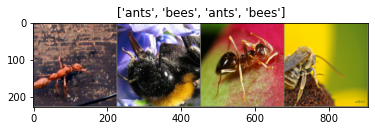

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs) # make a grid of images from a batch
imshow(out, title=[class_names[x] for x in classes])

### Model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# Load ResNet18
model_conv = models.resnet18(weights='DEFAULT')

In [9]:
# Freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False
# get the number of features in the fully connected layer
num_ftrs = model_conv.fc.in_features
# Replace the fully connected layer with a new one with 2 outputs
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

### Understand Training

In [10]:
correct = 0
for images, labels in dataloaders['train']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_conv(images)
    predicted = torch.argmax(outputs, dim=1)
    correct += (predicted == labels).sum().item()
    print("Input shape: ", images.shape)
    print("Label shape: ", labels.shape)
    print("Label: ", labels)
    print("Output shape: ", outputs.shape)
    print("Output: ", outputs)
    print("Predicted: ", predicted)
    print("Correct: ", correct)
    break

Input shape:  torch.Size([4, 3, 224, 224])
Label shape:  torch.Size([4])
Label:  tensor([1, 1, 1, 0], device='cuda:0')
Output shape:  torch.Size([4, 2])
Output:  tensor([[-1.0351, -0.3600],
        [-0.7642, -0.0542],
        [-1.3909,  0.8384],
        [-0.7413, -0.0479]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted:  tensor([1, 1, 1, 1], device='cuda:0')
Correct:  3


### Training

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
from pytorch_training import train_model

metrics = train_model(25, model_conv, criterion, optimizer, dataloaders['train'], dataloaders['val'], device, lr_scheduler)

  0%|          | 0/25 [00:00<?, ?epochs/s]

Epoch 01/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 02/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 03/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 04/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 05/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 06/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 07/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 08/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 09/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 10/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 11/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 12/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 13/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 14/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 15/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 16/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 17/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 18/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 19/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 20/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 21/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 22/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 23/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 24/25:   0%|          | 0/100 [00:00<?, ?batches/s]

Epoch 25/25:   0%|          | 0/100 [00:00<?, ?batches/s]

### Visualize some predictions 

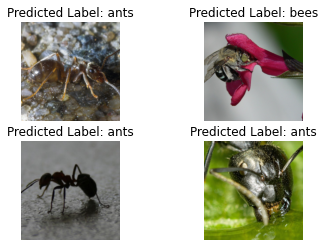

In [15]:
fig = plt.figure()
shown_batch = 0
with torch.no_grad():
    for images, labels in dataloaders['val']:
        shown_batch += 1
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_conv(images) # The output is of shape (4,2)
        _, preds = torch.max(outputs, 1) # The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            ax = plt.subplot(2,2,i+1)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
        break